In [7]:
import numpy as np
import pandas as pd

In [8]:
def sim_block(subject, parameters, cfg):
    print(f'subject {subject}')

    # set parameters
    alpha = parameters['alpha']
    lambda_ = parameters['lambda']
    beta = parameters['beta']
    omega = parameters['omega']

    # set initial var
    Nstates = cfg['Nstates'] # 2 states in second stage
    Narms = cfg['Narms'] # 2 offered options in each state
    Nblocks = cfg['Nblocks']
    Ntrials_perblock = cfg['Ntrials_perblock']
    expvalues = cfg['rndwlk']
    state_transition = np.array([[0.7, 0.3], [0.3, 0.7]])
    df = pd.DataFrame()

    for block in range(1, Nblocks + 1):
        # initialize Qmf values on each block
        Qmf1 = np.full(Narms, 0.5) # stage 1 - only one state
        Qmf2 = np.full((Nstates, Narms), 0.5) # stage 2 - two states

        # initialize Qmb values - only for first stage - second stage is identical to MF
        Qmb1 = np.full(Narms, 0.5)

        for trial in range(1, Ntrials_perblock + 1):
            # define first stage Qmb values based on MF values of second stage and state transitions.
            Qmb1[0] = state_transition[0, 0] * max(Qmf2[0, :]) + state_transition[1, 0] * max(Qmf2[1, :])
            Qmb1[1] = state_transition[0, 1] * max(Qmf2[0, :]) + state_transition[1, 1] * max(Qmf2[1, :])

            # integrate MF and MB values modulated by omega parameter
            Qnet1 = omega * Qmb1 + (1 - omega) * Qmf1

            # make first-stage choice
            p1 = np.exp(beta * Qnet1) / np.sum(np.exp(beta * Qnet1))
            choice1 = np.random.choice(range(Narms), p=p1)
            unchosen1 = [i for i in range(Narms) if i != choice1]

            # sample state transition based on first stage choice
            state = np.random.choice(range(Nstates), p=state_transition[:, choice1])
            state_prob = state_transition[state, choice1]

            # second stage choice
            p2 = np.exp(beta * Qmf2[state, :]) / np.sum(np.exp(beta* Qmf2[state, :]))
            choice2 = np.random.choice(range(Narms), p=p2)
            unchosen2 = [i for i in range(Narms) if i != choice2]

            # sample outcome
            if state == 0:
                expval_ch = expvalues[choice2, trial - 1]
                expval_unch = expvalues[unchosen2[0], trial - 1]
            else:
                expval_ch = expvalues[choice2 + 2, trial - 1] # for state B, it is 3rd and 4th row of expvalues csv
                expval_unch = expvalues[unchosen2[0] + 2, trial - 1]

            reward = np.random.choice([0, 1], p=[1 - expval_ch, expval_ch])

            # save trial's data
            dfnew = pd.DataFrame({
                'subject': [subject],
                'block': [block],
                'trial': [trial],
                'first_trial_in_block': [int(trial == 1)],
                'choice1': [choice1],
                'state': [state],
                'state_prob': [state_prob],
                'choice2': [choice2],
                'expval_ch': [expval_ch],
                'expval_unch': [expval_unch],
                'reward': [reward]
            })

            # bind to the overall df
            df = pd.concat([df, dfnew], ignore_index=True)

            # updating Qmf values
            # Prediction errors
            PE2 = reward - Qmf2[state, choice2] # second stage reward-based prediction error
            PE1 = Qmf2[state, choice2] - Qmf1[choice1] # first stage prediction error

            # second stage update
            Qmf2[state, choice2] = Qmf2[state, choice2] + alpha * PE2
            # first stage update with an eligibility trace for the second-stage prediction error
            Qmf1[choice1] = Qmf1[choice1] + alpha * PE1 + lambda_ * alpha * PE2

    return df

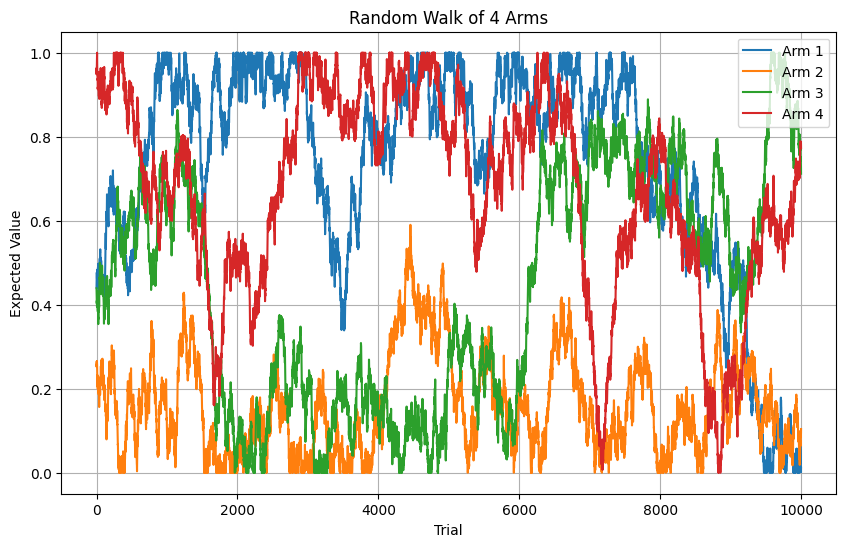

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def generate_random_walk(num_arms=4, num_trials=100, step_size=0.01):
    """
    Generates a random walk for the expected values of multiple arms.

    Parameters:
    num_arms (int): Number of arms.
    num_trials (int): Number of trials.
    step_size (float): Maximum change in expected value per step.

    Returns:
    np.ndarray: A matrix of size (num_arms, num_trials) with the random walk values.
    """
    # Initialize the expected values to random values between 0 and 1
    expvalues = np.random.rand(num_arms, num_trials)
    
    for trial in range(1, num_trials):
        # Generate random steps for each arm
        steps = np.random.uniform(-step_size, step_size, num_arms)
        # Update the expected values
        expvalues[:, trial] = expvalues[:, trial - 1] + steps
        # Ensure values remain between 0 and 1
        expvalues[:, trial] = np.clip(expvalues[:, trial], 0, 1)
    
    return expvalues

# Parameters
num_arms = 4
num_trials = 10000
step_size = 0.02

# Generate the random walk
random_walk = generate_random_walk(num_arms, num_trials, step_size)

# Plot the random walk
plt.figure(figsize=(10, 6))
for arm in range(num_arms):
    plt.plot(random_walk[arm], label=f'Arm {arm + 1}')

plt.xlabel('Trial')
plt.ylabel('Expected Value')
plt.title('Random Walk of 4 Arms')
plt.legend()
plt.grid(True)
plt.show()


In [10]:
import pandas as pd
cfg = {
    'Nstates': 2,
    'Narms': 2,
    'Nblocks': 4,
    'Ntrials_perblock': 50,
    'rndwlk': random_walk
}
df=sim_block(1, {'alpha': 0.3, 'alpha2': 0.3, 'lambda': 0.5, 'beta': 3, 'beta2': 3, 'omega': 1}, cfg)

subject 1


In [11]:
#regression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming df is already defined

# Data manipulation equivalent to the R code
df['reward'] = df['reward'].astype('category')
df['reward_oneback'] = df['reward'].shift(1)
df['repeat_state'] = df['state'] == df['state'].shift(1)
df['stay1'] = df['choice1'] == df['choice1'].shift(1)
df['stay2'] = df['choice2'] == df['choice2'].shift(1)
df['transition'] = np.where(df['state_prob'] == 0.7, "common", "rare")
df['previous_transition'] = df['transition'].shift(1)

# Drop rows with NA values
df = df.dropna()

# Group by and summarize equivalent to the R code
summary = df.groupby(['reward_oneback', 'previous_transition'])['stay1'].mean().reset_index()
print(summary)



  reward_oneback previous_transition     stay1
0              0              common  0.338710
1              0                rare  0.518519
2              1              common  0.593023
3              1                rare  0.416667


C:\Users\Ido\AppData\Local\Temp\ipykernel_25840\1265577726.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df.groupby(['reward_oneback', 'previous_transition'])['stay1'].mean().reset_index()


In [14]:
import bambi as bmb
import arviz as az
# Model fitting equivalent to the R code
model = bmb.Model(
    'stay1 ~ reward_oneback*previous_transition ',
    df,
    family='bernoulli'
)

# Fit the model
results = model.fit()

Modeling the probability that stay1==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, reward_oneback, previous_transition, reward_oneback:previous_transition]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


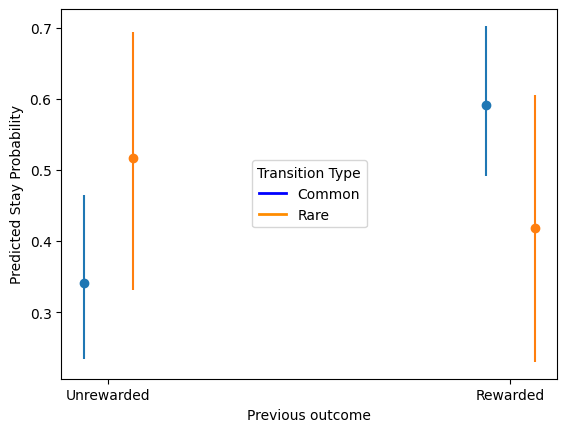

In [46]:
# Plot the predictions
fig, ax = plt.subplots()
bmb.interpret.plot_predictions(
    model,
    results,
    conditional=["reward_oneback", "previous_transition"],
    target='mean',
    use_hdi=True,
    prob=0.95,
    legend=False,  # Disable the default legend
    ax=ax
)

# Customize the plot
ax.set_xlabel('Previous outcome')
ax.set_ylabel('Predicted Stay Probability')
ax.set_xticks([0, 1])
ax.set_xticklabels(["Unrewarded", "Rewarded"])

# Manually add legend
legend_elements = [
    plt.Line2D([0], [0], color='blue', lw=2, linestyle='-', label='Common'),
    plt.Line2D([0], [0], color='darkorange', lw=2, linestyle='-', label='Rare')
]
ax.legend(handles=legend_elements, title='Transition Type', loc='center')

plt.show()


Install cmdstan py from here https://mc-stan.org/cmdstanpy/installation.html

In [57]:
import os
from cmdstanpy import CmdStanModel
stan_file = os.path.join('models','two_step_task', 'stan', 'two_step_task_stan.stan')
model = CmdStanModel(stan_file=stan_file)
# specify data file
data_file = os.path.join('data', 'stan_ready_data_files', 'artificial_standata_two_step_task.json')
fit = model.sample(data=data_file)

13:39:48 - cmdstanpy - INFO - compiling stan file C:\Users\Ido\MYDRIV~1\R\WORKSH~1\models\TWO_ST~1\stan\two_step_task_stan.stan to exe file C:\Users\Ido\My Drive\R\Workshop-Reinforcement-Learning-Modeling-For-Human-Choice-Behavior\models\two_step_task\stan\two_step_task_stan.exe
13:40:23 - cmdstanpy - INFO - compiled model executable: C:\Users\Ido\My Drive\R\Workshop-Reinforcement-Learning-Modeling-For-Human-Choice-Behavior\models\two_step_task\stan\two_step_task_stan.exe
13:40:24 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

13:40:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
13:40:24 - cmdstanpy - ERROR - Chain [2] error: error during processing Operation not permitted
13:40:24 - cmdstanpy - ERROR - Chain [4] error: error during processing Operation not permitted
13:40:24 - cmdstanpy - ERROR - Chain [3] error: error during processing Operation not permitted


13:40:24 - cmdstanpy - INFO - CmdStan done processing.


RuntimeError: Error during sampling:
Exception: mismatch in number dimensions declared and found in context; processing stage=data initialization; variable name=Nsubjects; dims declared=(); dims found=(1) (in 'two_step_task_stan.stan', line 5, column 2 to column 25)
Exception: mismatch in number dimensions declared and found in context; processing stage=data initialization; variable name=Nsubjects; dims declared=(); dims found=(1) (in 'two_step_task_stan.stan', line 5, column 2 to column 25)
Exception: mismatch in number dimensions declared and found in context; processing stage=data initialization; variable name=Nsubjects; dims declared=(); dims found=(1) (in 'two_step_task_stan.stan', line 5, column 2 to column 25)
Exception: mismatch in number dimensions declared and found in context; processing stage=data initialization; variable name=Nsubjects; dims declared=(); dims found=(1) (in 'two_step_task_stan.stan', line 5, column 2 to column 25)
Command and output files:
RunSet: chains=4, chain_ids=[1, 2, 3, 4], num_processes=4
 cmd (chain 1):
	['C:\\Users\\Ido\\My Drive\\R\\Workshop-Reinforcement-Learning-Modeling-For-Human-Choice-Behavior\\models\\two_step_task\\stan\\two_step_task_stan.exe', 'id=1', 'random', 'seed=4088', 'data', 'file=data\\stan_ready_data_files\\artificial_standata_two_step_task.json', 'output', 'file=C:\\Users\\Ido\\AppData\\Local\\Temp\\tmp9bhb0plf\\two_step_task_stanqq6v3nco\\two_step_task_stan-20240710134024_1.csv', 'method=sample', 'algorithm=hmc', 'adapt', 'engaged=1']
 retcodes=[1, 1, 1, 1]
 per-chain output files (showing chain 1 only):
 csv_file:
	C:\Users\Ido\AppData\Local\Temp\tmp9bhb0plf\two_step_task_stanqq6v3nco\two_step_task_stan-20240710134024_1.csv
 console_msgs (if any):
	C:\Users\Ido\AppData\Local\Temp\tmp9bhb0plf\two_step_task_stanqq6v3nco\two_step_task_stan-20240710134024_0-stdout.txt
Consider re-running with show_console=True if the above output is unclear!